In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Libraries, data, and functions

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import pandas as pd
import mpl_toolkits.mplot3d as plt3d

from tensorflow.keras.layers import Dense,Reshape, Dropout, Activation, Flatten, Conv1D, MaxPooling1D, UpSampling1D, Input

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split

In [ ]:
#Function which plots the 3D traingle
minmax = (-1,1)

def Plot_2(v1, v2, v3, vv1, vv2, vv3):
  fig = plt.figure()
  fig.set_size_inches(5,5)
  ax = fig.add_subplot(111, projection='3d')
  
  X = np.array([v1,v2,v3])
  Y = np.array([vv1,vv2,vv3])
  
  l0x, ll0x = np.linspace(v1[0], v2[0], 50), np.linspace(vv1[0], vv2[0], 50)
  l1x, ll1x = np.linspace(v2[0], v3[0], 50), np.linspace(vv2[0], vv3[0], 50)
  l2x, ll2x = np.linspace(v3[0], v1[0], 50), np.linspace(vv3[0], vv1[0], 50)
  l0y, ll0y = np.linspace(v1[1], v2[1], 50), np.linspace(vv1[1], vv2[1], 50)
  l1y, ll1y = np.linspace(v2[1], v3[1], 50), np.linspace(vv2[1], vv3[1], 50)
  l2y, ll2y = np.linspace(v3[1], v1[1], 50), np.linspace(vv3[1], vv1[1], 50)
  l0z, ll0z = np.linspace(v1[2], v2[2], 50), np.linspace(vv1[2], vv2[2], 50)
  l1z, ll1z = np.linspace(v2[2], v3[2], 50), np.linspace(vv2[2], vv3[2], 50)
  l2z, ll2z = np.linspace(v3[2], v1[2], 50), np.linspace(vv3[2], vv1[2], 50)

  #Drawing lines
  ax.scatter(l0x, l0y, l0z, color='red', marker='s', s = 1, alpha = 0.1), ax.scatter(ll0x, ll0y, ll0z, color='black', marker='s', s = 1, alpha = 0.1)
  ax.scatter(l1x, l1y, l1z, color='red', marker='s', s = 1, alpha = 0.1), ax.scatter(ll1x, ll1y, ll1z, color='black', marker='s', s = 1, alpha = 0.1)
  ax.scatter(l2x, l2y, l2z, color='red', marker='s', s = 1, alpha = 0.1), ax.scatter(ll2x, ll2y, ll2z, color='black', marker='s', s = 1, alpha = 0.1)

  #plot the nodes
  for x, y, z in X:
    ax.scatter(x, y, z, color='red', marker='o', s=30)
  for x, y, z in Y:
    ax.scatter(x, y, z, color='black', marker='o', s=30)

  ax.set_xlim(minmax)
  ax.set_ylim(minmax) 
  ax.set_zlim(minmax) 


In [ ]:
def side_lens(v):
  vx,vy,vz = np.array_split(v , 3)
  return np.array([np.linalg.norm(vx-vy), 
                   np.linalg.norm(vy-vz), 
                   np.linalg.norm(vz-vx)])

This cell is for importing larger datasets from google drive instead of remaking them.

### Prepping data

In [ ]:
# Euclidean data
DATA_SIZE = 200000
x_data = np.array(np.random.random((DATA_SIZE,9,)) )

In [ ]:
# Splitting the array into validation, training, and test sets

# Euclidean training x-data
x_train,  x_val = train_test_split(x_data , test_size = 0.1  , shuffle = False)
x_train, x_test = train_test_split(x_train, test_size = 1./9., shuffle = False)

# Trying a different loss function

In this notebook I am going try to alter the format of the loss function to that which actively encourages the learning of invarients. The invarients I am going to truy force the network to learn are the side lenghts. Previously, I have used an input vector $\vec{X}$ yielding a scalar loss *L*. I used a MSE loss function up until this point.
$$ 
\vec{X}= \begin{pmatrix}
x_1\\y_1\\z_1\\
x_2\\y_2\\z_2\\
x_3\\y_3\\z_3
\end{pmatrix},
\quad 
L(\vec{X},\vec{X}') = 
\begin{pmatrix} 
l_1  
\end{pmatrix}.
$$

When we are changing the loss function, it is important to maintain continuity nessacary for backpropagation. Practically this means using tensorflow operations when coding it. Also, the loss function has an input of two tensors, and it should return a value (or values) reduced along the last axis of the input tensor. In this case, it should return a scalar.

I used a number of steps in the function. The following steps I preformed for both y_true, and y_pred in order to get the side lenghts of the triangles.


1.   Reshaping input to 3x3 matrix
$$ 
\textbf{X}= 
\begin{pmatrix}
x_1,y_1,z_1\\
x_2,y_2,z_2\\
x_3,y_3,z_3
\end{pmatrix}
$$

2.   Permuting the rows of the matrix according to and subtracting it from the original matrix, and squaring the entries\
$$ 
\left(
\begin{pmatrix}
x_1,y_1,z_1\\
x_2,y_2,z_2\\
x_3,y_3,z_3
\end{pmatrix}  
-
\begin{pmatrix}
x_2,y_2,z_2\\
x_3,y_3,z_3\\
x_1,y_1,z_1
\end{pmatrix}
\right)^2 
=
\begin{pmatrix} 
(x_1-x_2)^2,(y_1-y_2)^2,(z_1-z_2)^2\\
(x_2-x_3)^2,(y_2-y_3)^2,(z_2-z_3)^2\\
(x_3-x_1)^2,(y_3-y_1)^2,(z_3-z_1)^2 
\end{pmatrix}
$$

3.   Summing aloong the horizontal entries and taking the squareroot
\begin{pmatrix} 
\sqrt{(x_1-x_2)^2+(y_1-y_2)^2+(z_1-z_2)^2}\\
\sqrt{(x_2-x_3)^2+(y_2-y_3)^2+(z_2-z_3)^2}\\
\sqrt{(x_3-x_1)^2+(y_3-y_1)^2+(z_3-z_1)^2} 
\end{pmatrix}


4.   Sum along the remaining axis to get the total side lenght
$$
l = \sqrt{(x_1-x_2)^2+(y_1-y_2)^2+(z_1-z_2)^2}+
\sqrt{(x_2-x_3)^2+(y_2-y_3)^2+(z_2-z_3)^2}+
\sqrt{(x_3-x_1)^2+(y_3-y_1)^2+(z_3-z_1)^2}
$$

5.   l is calculated for y_true, and y_pred and then the two l's are subtracted and squared.

This loss function tends to 0 as the two triangles sides tend to eachother.




Note: Changing the optimizer to ADAM now yiedlds much better results than RMSprop

## Loss function

In [ ]:
def loss_function(y_true, y_pred):

  bs = len(y_true)
  y_true, y_pred = tf.reshape(y_true, (bs,3,3)), tf.reshape(y_pred,(bs,3,3)) 

  perm_rows = tf.linalg.LinearOperatorPermutation([1,2,0])
  true_dist = tf.sqrt(tf.reduce_sum(tf.math.squared_difference( y_true, tf.matmul(perm_rows,y_true) ), axis=-1, keepdims=True))
  pred_dist = tf.sqrt(tf.reduce_sum(tf.math.squared_difference( y_pred, tf.matmul(perm_rows,y_pred) ), axis=-1, keepdims=True))

  return tf.reduce_sum( tf.abs( tf.math.subtract(true_dist, pred_dist) ) , axis = 1)  

In [ ]:
def side_lens(v):
  vx,vy,vz = np.array_split(v , 3)
  return np.array([np.linalg.norm(vx-vy), 
                   np.linalg.norm(vy-vz), 
                   np.linalg.norm(vz-vx)])

In [ ]:
#Testing to see if the loss fn indeed gives the side lenghts

y_true = tf.constant([x_train[0],x_train[1]],dtype = 'float')
y_pred = tf.constant([x_train[1],x_train[0]],dtype = 'float')

print(loss_function(y_true, y_pred))
print(np.sum( np.abs(side_lens(x_train[0]) - side_lens(x_train[1])) ))

tf.Tensor(
[[0.6320138]
 [0.6320138]], shape=(2, 1), dtype=float32)
0.6320138038166175


## Layers 9r-9r-9s
Poor performance

In [ ]:
# Build
input_img = Input(shape=(9,))
l1      = Dense(   9, activation = tf.keras.layers.LeakyReLU() )(input_img)
encoded = Dense(   3, activation = tf.keras.layers.LeakyReLU() )(l1)
decoded = Dense(   9, activation = 'linear'                    )(encoded)
model = Model(input_img, decoded)


model.compile(optimizer=keras.optimizers.Adam(amsgrad=True), loss=loss_function)
history = model.fit(x_train, x_train,     
                            epochs=100,
                            batch_size=256,
                            validation_data=(x_val, x_val),
                            verbose = 1)

Epoch 1/100
625/625 [==============================] - 2s 2ms/step - loss: 0.6634 - val_loss: 0.5306
Epoch 2/100
625/625 [==============================] - 1s 1ms/step - loss: 0.5195 - val_loss: 0.5027
Epoch 3/100
625/625 [==============================] - 1s 1ms/step - loss: 0.4965 - val_loss: 0.4759
Epoch 4/100
625/625 [==============================] - 1s 1ms/step - loss: 0.4665 - val_loss: 0.4459
Epoch 5/100
625/625 [==============================] - 1s 1ms/step - loss: 0.4422 - val_loss: 0.4338
Epoch 6/100
625/625 [==============================] - 1s 1ms/step - loss: 0.4291 - val_loss: 0.4169
Epoch 7/100
625/625 [==============================] - 1s 1ms/step - loss: 0.4108 - val_loss: 0.3931
Epoch 8/100
625/625 [==============================] - 1s 1ms/step - loss: 0.3880 - val_loss: 0.3783
Epoch 9/100
625/625 [==============================] - 1s 1ms/step - loss: 0.3748 - val_loss: 0.3709
Epoch 10/100
625/625 [==============================] - 1s 1ms/step - loss: 0.3694 - val_lo

625/625 [==============================] - 1s 1ms/step - loss: 0.3412
Percent Error in each side roconstruction: 0.03610137223739117 0.47870352986154396 0.014322040846208087 

Percent Error in each side roconstruction: 0.11847896632682643 4.088862975996969 0.009673381943664482 

Percent Error in each side roconstruction: 0.7014831344192841 0.42327065131914055 0.005615003018258241 



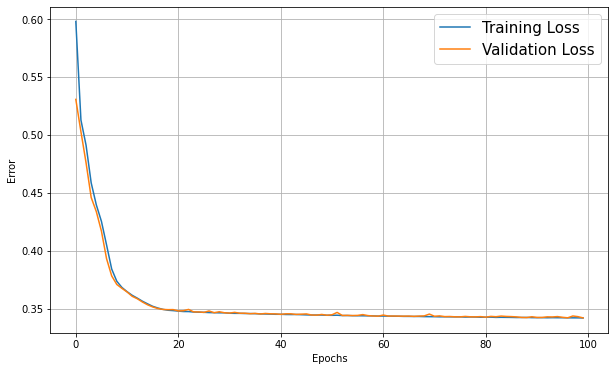

In [ ]:
# Test Loss
model.evaluate(x_test,x_test)

# Plot Training Loss and Validation Loss
plt.figure(figsize=(10,6))
plt.plot(range(len(history.history['loss'    ])), history.history['loss'    ], label='Training Loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label='Validation Loss')
matplotlib.rc('font', size=15)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.grid()

# Printing Reconstructions and side lenghts
reconstructed = model.predict(x_test)
for i in range(3):
    # Display original and reconstructed
    vx,vy,vz = np.array_split(x_test[i] , 3)
    vvx,vvy,vvz = np.array_split(reconstructed[i] , 3)

    print("Percent Error in each side roconstruction:",
          (np.abs(np.linalg.norm(vx-vy)-np.linalg.norm(vvx-vvy)))/np.abs(np.linalg.norm(vx-vy)),
          (np.abs(np.linalg.norm(vy-vz)-np.linalg.norm(vvy-vvz)))/np.abs(np.linalg.norm(vy-vz)),
          (np.abs(np.linalg.norm(vz-vx)-np.linalg.norm(vvz-vvx)))/np.abs(np.linalg.norm(vz-vx)),"\n")
    #Plot_2(vx,vy,vz,vvx,vvy,vvz)

## Layers 256r-3r-9s
Much better performance with ADAM and LeakyReLu. Deepening 1st layer may help preform side lenght operation.

In [ ]:
# Build
input_img = Input(shape=(9,))
l1      = Dense( 256, activation = tf.keras.layers.LeakyReLU() )(input_img)
encoded = Dense(   3, activation = tf.keras.layers.LeakyReLU() )(l1)
l2      = Dense( 256, activation = tf.keras.layers.LeakyReLU() )(encoded)
decoded = Dense(   9, activation = 'linear'                    )(l2)
model = Model(input_img, decoded)

# Compile and Train 
model.compile(optimizer=keras.optimizers.Adam(amsgrad=True), loss=loss_function)
history = model.fit(x_train, x_train,     # For autoencoders input data = target data
                  epochs=1000,
                  batch_size=32,
                  validation_data=(x_val, x_val),
                  verbose = 1)

Epoch 1/1000
5000/5000 [==============================] - 6s 1ms/step - loss: 0.5843 - val_loss: 0.3798
Epoch 2/1000
5000/5000 [==============================] - 6s 1ms/step - loss: 0.3124 - val_loss: 0.2069
Epoch 3/1000
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1735 - val_loss: 0.1635
Epoch 4/1000
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1402 - val_loss: 0.1359
Epoch 5/1000
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1236 - val_loss: 0.0875
Epoch 6/1000
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1123 - val_loss: 0.1007
Epoch 7/1000
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1042 - val_loss: 0.1068
Epoch 8/1000
5000/5000 [==============================] - 6s 1ms/step - loss: 0.0986 - val_loss: 0.0835
Epoch 9/1000
5000/5000 [==============================] - 6s 1ms/step - loss: 0.0958 - val_loss: 0.0794
Epoch 10/1000
5000/5000 [==============================] - 6s 1m

KeyboardInterrupt: ignored

In [ ]:
model.fit(x_train, x_train,     # For autoencoders input data = target data
                  epochs=1000,
                  batch_size=32,
                  validation_data=(x_val, x_val),
                  verbose = 1)

In [ ]:
model.evaluate(x=x_test,y=x_test)

625/625 [==============================] - 1s 969us/step - loss: 0.0059


0.0058831628412008286

In [ ]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               2560      
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 771       
_________________________________________________________________
dense_27 (Dense)             (None, 256)               1024      
_________________________________________________________________
dense_28 (Dense)             (None, 9)                 2313      
Total params: 6,668
Trainable params: 6,668
Non-trainable params: 0
_________________________________________________________________


In [ ]:
input   = model.get_layer('input_8')
l1      = model.get_layer('dense_25')
latent  = model.get_layer('dense_26')
l2      = model.get_layer('dense_27')
decode  = model.get_layer('dense_28')

#Building encoder
encoder = Sequential()
encoder.add(input )
encoder.add(l1    )
encoder.add(latent)
encoder.summary()

#Building decoder
decoder = Sequential()
decoder.add(Flatten(input_shape=(3,)))
decoder.add(l2)
decoder.add(decode)
decoder.compile()
decoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 256)               2560      
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 771       
Total params: 3,331
Trainable params: 3,331
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3)                 0         
_________________________________________________________________
dense_27 (Dense)             (None, 256)               1024      
_________________________________________________________________
dense_28 (Dense)             (None, 9)                 2313      
Total params: 3,337
Trainable 

625/625 [==============================] - 1s 970us/step - loss: 0.0059
Av. side error =  0.07670177860519813
Error in each side: -0.002 0.008 0.001 
 l1 =  0.517 ll1 =  0.52 
 l2 =  0.924 ll2 =  0.917 
 l3 =  0.824 ll3 =  0.824 

Error in each side: 0.0 0.004 0.004 
 l1 =  0.658 ll1 =  0.657 
 l2 =  0.807 ll2 =  0.803 
 l3 =  0.468 ll3 =  0.464 

Error in each side: 0.001 0.001 -0.002 
 l1 =  0.359 ll1 =  0.358 
 l2 =  0.409 ll2 =  0.409 
 l3 =  0.7 ll3 =  0.702 

Error in each side: 0.003 -0.0 -0.002 
 l1 =  0.38 ll1 =  0.377 
 l2 =  0.51 ll2 =  0.51 
 l3 =  0.859 ll3 =  0.861 

Error in each side: 0.002 -0.001 -0.001 
 l1 =  0.513 ll1 =  0.512 
 l2 =  0.41 ll2 =  0.41 
 l3 =  0.653 ll3 =  0.654 

Error in each side: -0.0 -0.0 0.002 
 l1 =  0.489 ll1 =  0.489 
 l2 =  0.874 ll2 =  0.874 
 l3 =  0.432 ll3 =  0.43 

Error in each side: -0.0 0.002 -0.0 
 l1 =  0.256 ll1 =  0.256 
 l2 =  0.628 ll2 =  0.627 
 l3 =  0.578 ll3 =  0.579 

Error in each side: 0.009 0.002 0.003 
 l1 =  0.721 ll

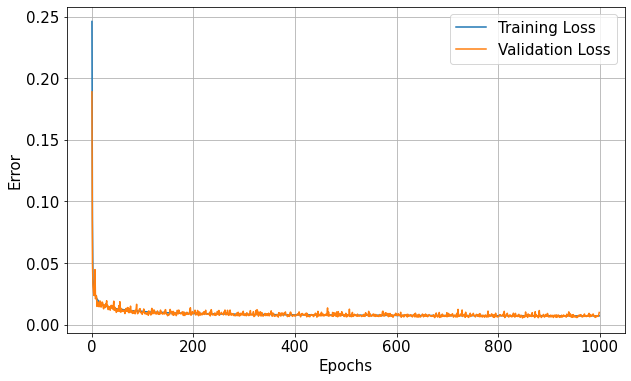

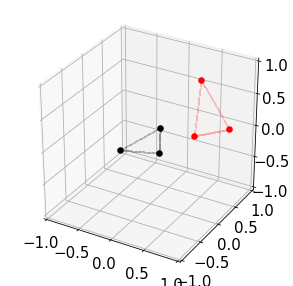

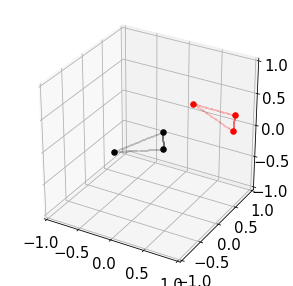

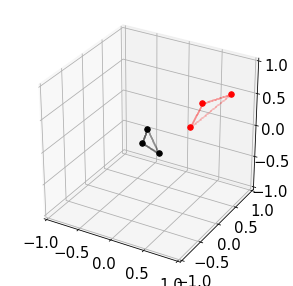

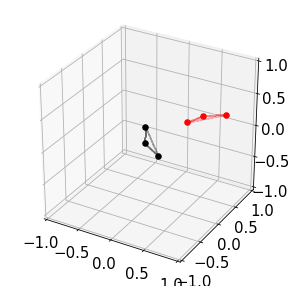

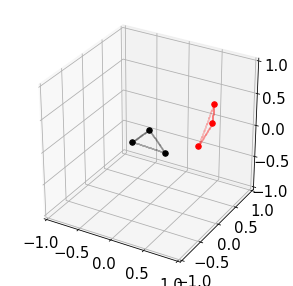

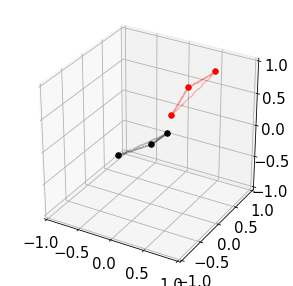

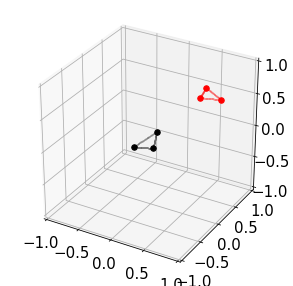

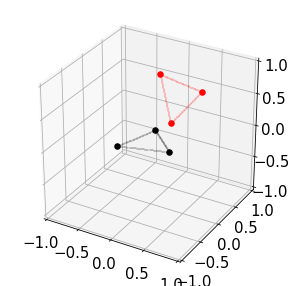

In [ ]:
# Test Loss
model.evaluate(x_test,x_test)
print('Av. side error = ',(model.evaluate(x_test,x_test))**0.5 )

# Plot Training Loss and Validation Loss
plt.figure(figsize=(10,6))
plt.plot(range(len(history.history['loss'    ])), history.history['loss'    ], label='Training Loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label='Validation Loss')
matplotlib.rc('font', size=15); plt.xlabel('Epochs'); plt.ylabel('Error'); plt.legend(); plt.grid();

# Printing Reconstructions and side lenghts
reconstructed = model.predict(x_test)
for i in range(8):
  # Display original and reconstructed
  v1,v2,v3 = np.array_split(x_test[i],3)
  vv1,vv2,vv3 = np.array_split(reconstructed[i],3)
  l1, l2, l3  = side_lens( x_test[i] )
  ll1, ll2, ll3 = side_lens( reconstructed[i] )

  print("Error in each side:",
        round(l1 - ll1,3),
        round(l2 - ll2,3),
        round(l3 - ll3,3),"\n",
        "l1 = ",round(l1,3),"ll1 = ", round(ll1,3) ,'\n',
        "l2 = ",round(l2,3),"ll2 = ", round(ll2,3) ,'\n',
        "l3 = ",round(l3,3),"ll3 = ", round(ll3,3) ,'\n')
  
  Plot_2(v1,v2,v3,vv1,vv2,vv3)

In [ ]:
model.save("/content/drive/MyDrive/Project/Custom_loss/Custom_Loss_Model"  )
encoder.save("/content/drive/MyDrive/Project/Custom_loss/Custom_Loss_Encoder")
decoder.save("/content/drive/MyDrive/Project/Custom_loss/Custom_Loss_Decoder")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Project/Custom_loss/Custom_Loss_Model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Project/Custom_loss/Custom_Loss_Model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Project/Custom_loss/Custom_Loss_Encoder/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Project/Custom_loss/Custom_Loss_Encoder/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Project/Custom_loss/Custom_Loss_Decoder/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Project/Custom_loss/Custom_Loss_Decoder/assets


## Latent dim comparison


In [ ]:
latent_dims   = np.arange(3,10)
test_loss = []

for dim in latent_dims:
  print('\n\n ================================================\n',
        '==================== dim = %d =================== \n'%(dim),
        '================================================\n\n')
  layers =[[256,  tf.keras.layers.LeakyReLU() ],
           [dim,  tf.keras.layers.LeakyReLU() ],
           [9,  'sigmoid']]
  
  model   = n_layer_model(layers = layers, optimizer='Adam', loss=loss_function)
  history = model.fit(x_train, x_train,     # For autoencoders input data = target data
                                          epochs=50,
                                          batch_size=32,
                                          validation_data=(x_val, x_val),
                                          verbose = 1)

  test_loss.append(model.evaluate(x_test,x_test) )


plt.figure(figsize=(10,5))
plt.plot(latent_dims, np.sqrt(test_loss), label = 'Total side lenght error' )
plt.xlabel('LD')
plt.ylabel('Loss')
plt.legend()

In [ ]:
cm = keras.models.load_model("/content/drive/MyDrive/Project/Custom_loss/Custom_Loss_Model"  ,
                                compile=False)

In [ ]:
cm.compile(loss = loss_function)

In [ ]:
cm.evaluate(x=x_test,y=x_test)

695/695 [==============================] - 1s 1ms/step - loss: 1.7026e-04


0.00017953419592231512

## Comparison with MSE loss

In [ ]:
# Build
input_img = Input(shape=(9,))
l1      = Dense( 256, activation = tf.keras.layers.LeakyReLU() )(input_img)
encoded = Dense(   3, activation = tf.keras.layers.LeakyReLU() )(l1)
l2      = Dense( 256, activation = tf.keras.layers.LeakyReLU() )(encoded)
decoded = Dense(   9, activation = 'linear'                    )(l2)
model = Model(input_img, decoded)

# Compile and Train 
model.compile(optimizer=keras.optimizers.Adam(amsgrad=True), loss='mse', metrics=[loss_function])
history = model.fit(x_train, x_train,     # For autoencoders input data = target data
                            epochs=1000,
                            batch_size=32,
                            validation_data=(x_val, x_val),
                            verbose = 1)

Epoch 1/1000
5000/5000 [==============================] - 7s 1ms/step - loss: 0.0601 - loss_function: 1.1682 - val_loss: 0.0498 - val_loss_function: 0.9996
Epoch 2/1000
5000/5000 [==============================] - 6s 1ms/step - loss: 0.0486 - loss_function: 0.9541 - val_loss: 0.0465 - val_loss_function: 0.9240
Epoch 3/1000
5000/5000 [==============================] - 6s 1ms/step - loss: 0.0459 - loss_function: 0.9089 - val_loss: 0.0447 - val_loss_function: 0.8873
Epoch 4/1000
5000/5000 [==============================] - 6s 1ms/step - loss: 0.0445 - loss_function: 0.8813 - val_loss: 0.0438 - val_loss_function: 0.8646
Epoch 5/1000
5000/5000 [==============================] - 6s 1ms/step - loss: 0.0436 - loss_function: 0.8657 - val_loss: 0.0429 - val_loss_function: 0.8634
Epoch 6/1000
5000/5000 [==============================] - 6s 1ms/step - loss: 0.0428 - loss_function: 0.8454 - val_loss: 0.0426 - val_loss_function: 0.8381
Epoch 7/1000
5000/5000 [==============================] - 6s 1ms

In [ ]:
model.evaluate(x_test,x_test)

625/625 [==============================] - 1s 997us/step - loss: 0.0193 - loss_function: 0.4844


[0.019347921013832092, 0.48436805605888367]

In [ ]:
0.48436805605888367/0.0059

82.09628068794639

In [ ]:
0.0059/3

0.0019666666666666665

In [ ]:
0.48436805605888367/3

0.16145601868629456

In [ ]:
0.1615/0.0019666666666666665


82.11864406779662